NHL Game Prediction Project

### Step 1: Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

### Step 2: Data Cleaning and Preparation

In [2]:
def load_data(file_2024):
    nhl_game_data_2024 = pd.read_csv(file_2024)
    return nhl_game_data_2024

In [3]:
nhl_game_data_2024 = load_data('final_nhl_data_2024.csv')

In [4]:
nhl_game_data_2024.shape

(1746, 20)

In [5]:
# This is a manual operation for now. If this isn't empty, find th eprior game with that goalie, and replace -- with that old sv%
nhl_game_data_2024.loc[nhl_game_data_2024['sv%'] == '--']

,date,time,venue,rest days,result,gf/gp,ga/gp,net goals,opponent,shots for,shots against,shot diff,pp opp/gp,ts/gp,pp%,pk%,fow%,team,goalie,sv%


In [6]:
def clean_data(df):
    # Explicitly create a copy of the DataFrame to avoid modifying a view
    df = df.copy()

    # Drop duplicates of games where a goalie switch happened
    columns_to_check = [
        "date", "time", "venue", "rest days", "result", "gf/gp", "ga/gp", "net goals",
        "opponent", "shots for", "shots against", "shot diff", "pp opp/gp", "ts/gp",
        "pp%", "pk%", "fow%", "team"
    ]
    df = df.drop_duplicates(subset=columns_to_check, keep='last')

    # Convert columns to appropriate types using .loc to avoid warnings
    df.loc[:, "date"] = pd.to_datetime(df["date"]).dt.strftime('%Y-%m-%d')
    df.loc[:, "opp_code"] = df["opponent"].astype("category").cat.codes
    df.loc[:, "team_code"] = df["team"].astype("category").cat.codes
    df.loc[:, "goalie_code"] = df["goalie"].astype("category").cat.codes
    df.loc[:, "hour"] = df["time"].fillna("0:00").str.replace(":.+", "", regex=True).astype(int)

    team_code_dict = dict(zip(df['team'].astype('category').cat.categories, range(len(df['team'].astype('category').cat.categories))))
    goalie_code_dict = dict(zip(df['goalie'].astype('category').cat.categories, range(len(df['goalie'].astype('category').cat.categories))))

    print("Team Code Dictionary:")
    print(team_code_dict)
    print("\nGoalie Code Dictionary:")
    print(goalie_code_dict)

    # Update home_win logic
    df.loc[:, "home_win"] = (
        ((df["venue"] == "Away") & (df["net goals"] < 0)) | 
        ((df["venue"] == "Home") & (df["net goals"] > 0))
    ).astype(int)

    # Handle special characters and missing values in percentages
    df.loc[:, "pp%"] = df["pp%"].replace('--', np.nan).astype(float)
    df.loc[:, "pk%"] = df["pk%"].replace('--', np.nan).astype(float)
    df.loc[:, "sv%"] = df["sv%"].astype(float)

    return df

In [7]:
nhl_game_data_2024 = clean_data(nhl_game_data_2024)

Team Code Dictionary:
{'Anaheim Ducks': 0, 'Boston Bruins': 1, 'Buffalo Sabres': 2, 'Calgary Flames': 3, 'Carolina Hurricanes': 4, 'Chicago Blackhawks': 5, 'Colorado Avalanche': 6, 'Columbus Blue Jackets': 7, 'Dallas Stars': 8, 'Detroit Red Wings': 9, 'Edmonton Oilers': 10, 'Florida Panthers': 11, 'Los Angeles Kings': 12, 'Minnesota Wild': 13, 'Montreal Canadiens': 14, 'Nashville Predators': 15, 'New Jersey Devils': 16, 'New York Islanders': 17, 'New York Rangers': 18, 'Ottawa Senators': 19, 'Philadelphia Flyers': 20, 'Pittsburgh Penguins': 21, 'San Jose Sharks': 22, 'Seattle Kraken': 23, 'St. Louis Blues': 24, 'Tampa Bay Lightning': 25, 'Toronto Maple Leafs': 26, 'Utah Hockey Club': 27, 'Vancouver Canucks': 28, 'Vegas Golden Knights': 29, 'Washington Capitals': 30, 'Winnipeg Jets': 31}

Goalie Code Dictionary:
{'Adin Hill': 0, 'Akira Schmid': 1, 'Aleksei Kolosov': 2, 'Alex Lyon': 3, 'Alex Nedeljkovic': 4, 'Alexandar Georgiev': 5, 'Andrei Vasilevskiy': 6, 'Anthony Stolarz': 7, 'Anton F

In [8]:
nhl_game_data_2024.head()

,date,time,venue,rest days,result,gf/gp,ga/gp,net goals,opponent,shots for,...,pk%,fow%,team,goalie,sv%,opp_code,team_code,goalie_code,hour,home_win
0,2024-10-04,13:00,Away,4,L,4,1,3,Buffalo Sabres,23,...,100.0,42.4,New Jersey Devils,Jacob Markstrom,0.968,2,16,36,13,0
1,2024-10-04,13:00,Home,4,W,1,4,-3,New Jersey Devils,31,...,100.0,57.6,Buffalo Sabres,Ukko-Pekka Luukkonen,0.864,16,2,86,13,0
2,2024-10-05,10:00,Home,0,W,3,1,2,Buffalo Sabres,37,...,100.0,64.7,New Jersey Devils,Jake Allen,0.944,2,16,37,10,1
3,2024-10-05,10:00,Away,0,L,1,3,-2,New Jersey Devils,18,...,75.0,35.3,Buffalo Sabres,Devon Levi,0.919,16,2,23,10,1
4,2024-10-08,19:00,Away,4,W,4,6,-2,Florida Panthers,28,...,100.0,48.4,Boston Bruins,Joonas Korpisalo,0.829,11,1,52,19,1


In [9]:
# check removed duplicates (was 2 should be 1 now)
nhl_game_data_2024.loc[(nhl_game_data_2024['team'] == 'Ottawa Senators') & (nhl_game_data_2024['date'] == '2024-10-14')]

,date,time,venue,rest days,result,gf/gp,ga/gp,net goals,opponent,shots for,...,pk%,fow%,team,goalie,sv%,opp_code,team_code,goalie_code,hour,home_win
91,2024-10-14,13:00,Home,1,W,8,7,1,Los Angeles Kings,41,...,40.0,44.1,Ottawa Senators,Mads Sogaard,0.765,12,19,66,13,1


In [10]:
nhl_game_data_2024.shape

(1662, 25)

### Step 4: Find rolling averages

In [11]:
# def rolling_averages(group, cols, new_cols):
#     rolling_stats = group[cols].shift(1).rolling(window=2, min_periods=1).mean()
#     group[new_cols] = rolling_stats
    
#     # rolling_stats = rolling_stats.fillna(group[cols])
#     # group = group.dropna(subset=new_cols)
#     # group[new_cols] = group[new_cols].fillna(0)
#     return group

def rolling_averages(group, cols, new_cols):
    # Calculate the rolling averages for all previous games (excluding the current game)
    rolling_stats = group[cols].expanding(min_periods=1).mean().shift(1)  # Shift to exclude current game
    group[new_cols] = rolling_stats
    
    return group


In [12]:
def apply_rolling_avg(df):
    stat_cols = ["gf/gp", "ga/gp", "shots for", "shots against", "pp opp/gp", "ts/gp", "pp%", "fow%"]
    avg_cols = [f"AVG_{c}" for c in stat_cols]

    df = df.groupby("team").apply(lambda x: rolling_averages(x, stat_cols, avg_cols))

    return df

In [13]:
nhl_game_data_2024 = apply_rolling_avg(nhl_game_data_2024)
nhl_game_data_2024 = nhl_game_data_2024.droplevel("team")
nhl_game_data_2024 = nhl_game_data_2024.sort_values(by="date")
nhl_game_data_2024.index = range(nhl_game_data_2024.shape[0])

C:\Users\riger\AppData\Local\Temp\ipykernel_41672\3725490225.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("team").apply(lambda x: rolling_averages(x, stat_cols, avg_cols))


In [14]:
nhl_game_data_2024.shape

(1662, 33)

In [15]:
nhl_game_data_2024.head(10)

,date,time,venue,rest days,result,gf/gp,ga/gp,net goals,opponent,shots for,...,hour,home_win,AVG_gf/gp,AVG_ga/gp,AVG_shots for,AVG_shots against,AVG_pp opp/gp,AVG_ts/gp,AVG_pp%,AVG_fow%
0,2024-10-04,13:00,Home,4,W,1,4,-3,New Jersey Devils,31,...,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-04,13:00,Away,4,L,4,1,3,Buffalo Sabres,23,...,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-05,10:00,Away,0,L,1,3,-2,New Jersey Devils,18,...,10,1,1.0,4.0,31.0,23.0,4.0,2.0,0.0,57.6
3,2024-10-05,10:00,Home,0,W,3,1,2,Buffalo Sabres,37,...,10,1,4.0,1.0,23.0,31.0,2.0,4.0,0.0,42.4
4,2024-10-08,19:00,Away,4,W,4,6,-2,Florida Panthers,28,...,19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2024-10-08,22:00,Home,4,L,5,2,3,Chicago Blackhawks,27,...,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2024-10-08,22:00,Away,4,W,2,5,-3,Utah Hockey Club,26,...,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2024-10-08,19:00,Home,4,L,6,4,2,Boston Bruins,35,...,19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2024-10-08,16:30,Away,4,L,3,2,1,Seattle Kraken,25,...,16,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2024-10-08,16:30,Home,4,L,2,3,-1,St. Louis Blues,32,...,16,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# def calculate_goalie_avg(group, cols, new_cols):
#     rolling_stats = group[cols].shift(1).rolling(window=2, min_periods=1).mean()
#     group[new_cols] = rolling_stats
    
#     # Optionally, handle missing values or drop NaNs if needed
#     group = group.dropna(subset=new_cols)
#     # group[new_cols] = group[new_cols].fillna(0)  # Optionally fill NaNs with 0

#     return group

def calculate_goalie_avg(group, cols, new_cols):
    # Calculate the cumulative average for all previous games (excluding current game)
    rolling_stats = group[cols].expanding(min_periods=1).mean().shift(1)  # Shift to exclude current game
    group[new_cols] = rolling_stats
    
    # Optionally, handle missing values or drop NaNs if needed
    group = group.dropna(subset=new_cols)
    # group[new_cols] = group[new_cols].fillna(0)  # Optionally fill NaNs with 0

    return group


In [17]:
def apply_goalie_avg(df):
    # Define columns for goalie stats and their corresponding average columns
    stat_cols = ["sv%"]  # Column to calculate the rolling average for
    avg_cols = ["AVG_sv%"]  # New column for rolling average

    # Apply the rolling average for each goalie
    df = df.groupby("goalie").apply(lambda x: calculate_goalie_avg(x, stat_cols, avg_cols))

    # Optionally reset the index and sort the data
    df = df.sort_values(by="date")
    df.index = range(df.shape[0])

    return df

# Apply the function to the dataset
nhl_game_data_2024 = apply_goalie_avg(nhl_game_data_2024)
nhl_game_data_2024.head()

C:\Users\riger\AppData\Local\Temp\ipykernel_41672\98356789.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("goalie").apply(lambda x: calculate_goalie_avg(x, stat_cols, avg_cols))


,date,time,venue,rest days,result,gf/gp,ga/gp,net goals,opponent,shots for,...,home_win,AVG_gf/gp,AVG_ga/gp,AVG_shots for,AVG_shots against,AVG_pp opp/gp,AVG_ts/gp,AVG_pp%,AVG_fow%,AVG_sv%
0,2024-10-10,19:30,Away,1,L,5,4,1,New York Islanders,26,...,0,5.0,2.0,27.0,26.0,1.0,3.0,0.0,50.00,0.923
1,2024-10-10,19:00,Home,4,W,2,4,-2,Toronto Maple Leafs,23,...,0,3.5,1.0,30.0,24.5,3.0,3.0,12.5,53.55,0.968
2,2024-10-10,19:00,Home,4,W,1,3,-2,Los Angeles Kings,33,...,0,1.0,3.5,24.5,30.0,3.0,3.0,0.0,46.45,0.864
3,2024-10-10,19:00,Away,1,L,1,3,-2,Ottawa Senators,32,...,1,6.0,4.0,35.0,28.0,6.0,4.0,0.0,51.60,0.857
4,2024-10-11,22:00,Home,1,L,4,3,1,St. Louis Blues,28,...,1,8.0,4.0,21.0,32.0,3.0,3.0,66.7,58.00,0.875


In [18]:
nhl_game_data_2024.shape

(1571, 34)

### Step 5: Creating game id's
* this will be useful later when combining the same home/away game into one row

In [19]:
def create_game_ids(df):
    # Ensure consistent sorting of 'team_pair'
    df['team_pair'] = df.apply(
        lambda row: tuple(sorted([row['team'], row['opponent']])), axis=1
    )

    # Combine 'date', 'time', and 'team_pair' to create a unique key
    df['game_key'] = (
    df['date'].astype(str) + '_' +
    df['time'].astype(str) + '_' +
    df['team_pair'].astype(str)
    )

    # assign string game_id to a unique game_key number (there will be entires with the same game_key that should have the same game_id)
    df['game_id'] = pd.factorize(df['game_key'])[0] + 1

    df.drop(columns=['team_pair', 'game_key'], inplace=True)

    return df


#### Note: 
You will notice that in the begining of the season, there is one Home or Away game per game. This is because when calculating rolling averages, you can't find the average of the team's first game. Therefore, I dropped all rows with NaN "AVG" columns. This leaves the dataset to start with every team's second game

#### Note: 
Not only is the team's first game dropped. A goalie's first game is also dropped since I cannot calculate that goalie's average sv% with no prior games from that goalie

#### Issue: 
This cuts my dataset 

In [20]:
nhl_game_data_2024 = create_game_ids(nhl_game_data_2024)
nhl_game_data_2024 = nhl_game_data_2024.sort_values('game_id')
nhl_game_data_2024.head()

,date,time,venue,rest days,result,gf/gp,ga/gp,net goals,opponent,shots for,...,AVG_gf/gp,AVG_ga/gp,AVG_shots for,AVG_shots against,AVG_pp opp/gp,AVG_ts/gp,AVG_pp%,AVG_fow%,AVG_sv%,game_id
0,2024-10-10,19:30,Away,1,L,5,4,1,New York Islanders,26,...,5.0,2.0,27.0,26.0,1.0,3.0,0.0,50.00,0.923,1
1,2024-10-10,19:00,Home,4,W,2,4,-2,Toronto Maple Leafs,23,...,3.5,1.0,30.0,24.5,3.0,3.0,12.5,53.55,0.968,2
2,2024-10-10,19:00,Home,4,W,1,3,-2,Los Angeles Kings,33,...,1.0,3.5,24.5,30.0,3.0,3.0,0.0,46.45,0.864,3
3,2024-10-10,19:00,Away,1,L,1,3,-2,Ottawa Senators,32,...,6.0,4.0,35.0,28.0,6.0,4.0,0.0,51.60,0.857,4
4,2024-10-11,22:00,Home,1,L,4,3,1,St. Louis Blues,28,...,8.0,4.0,21.0,32.0,3.0,3.0,66.7,58.00,0.875,5


In [21]:
nhl_game_data_2024.shape

(1571, 35)

In [22]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


### Step 4: Combining Home and Away

In [23]:
# This is an example of a game with both Hoem and Away perspectives
# I will be combining these games, differenciated by 'home_' and 'away_' stats
nhl_game_data_2024.loc[nhl_game_data_2024['game_id'] == 25]

,date,time,venue,rest days,result,gf/gp,ga/gp,net goals,opponent,shots for,shots against,shot diff,pp opp/gp,ts/gp,pp%,pk%,fow%,team,goalie,sv%,opp_code,team_code,goalie_code,hour,home_win,AVG_gf/gp,AVG_ga/gp,AVG_shots for,AVG_shots against,AVG_pp opp/gp,AVG_ts/gp,AVG_pp%,AVG_fow%,AVG_sv%,game_id
43,2024-10-15,19:00,Home,2,W,3,4,-1,Florida Panthers,38,22,16,2,3,0.0,100.0,57.4,Columbus Blue Jackets,Elvis Merzlikins,0.818,11,7,27,19,0,4.00,3.50,28.0,28.00,3.00,3.5,33.3,44.80,0.885,25
34,2024-10-15,19:00,Away,0,L,4,3,1,Columbus Blue Jackets,22,38,-16,3,2,0.0,100.0,42.6,Florida Panthers,Spencer Knight,0.921,7,11,80,19,0,3.25,3.75,29.5,28.25,3.75,3.5,17.5,47.45,0.846,25


In [24]:
def combine_home_away_games(df):
    combined_rows = []

    # Group by a unique 'game_id'
    for _, group in df.groupby('game_id'):
        # Ensure there's exactly 1 home and 1 away game for each group
        home_games = group[group['venue'] == 'Home']
        away_games = group[group['venue'] == 'Away']     

        if len(home_games) == 1 and len(away_games) == 1:
            # Get the home and away rows
            home_game = home_games.iloc[0]
            away_game = away_games.iloc[0]

            # Create a new row combining home and away features
            combined_row = {
                'game_id': home_game['game_id'],
                'date': home_game['date'],
                'time': home_game['time'],
                # 'venue_code': home_game['venue_code'],
                'opp_code': away_game['opp_code'],
                'team_code': away_game['team_code'],
                'home_team': home_game['team'],
                'away_team': away_game['team'],
                'home_goalie': home_game['goalie'],
                'away_goalie': away_game['goalie'],
                'home_goalie_code': home_game['goalie_code'],
                'away_goalie_code': away_game['goalie_code'],
                'hour': home_game['hour'],
                'rest_days_home': home_game['rest days'],
                'rest_days_away': away_game['rest days'],
                'home_AVG_gf/gp': home_game['AVG_gf/gp'],
                'home_AVG_ga/gp': home_game['AVG_ga/gp'],
                'home_AVG_shots for': home_game['AVG_shots for'],
                'home_AVG_shots against': home_game['AVG_shots against'],
                'home_AVG_pp opp/gp': home_game['AVG_pp opp/gp'],
                'home_AVG_ts/gp': home_game['AVG_ts/gp'],
                'home_AVG_pp%': home_game['AVG_pp%'],
                'home_AVG_fow%': home_game['AVG_fow%'],
                'home_AVG_sv%': home_game['AVG_sv%'],
                'away_AVG_gf/gp': away_game['AVG_gf/gp'],
                'away_AVG_ga/gp': away_game['AVG_ga/gp'],
                'away_AVG_shots for': away_game['AVG_shots for'],
                'away_AVG_shots against': away_game['AVG_shots against'],
                'away_AVG_pp opp/gp': away_game['AVG_pp opp/gp'],
                'away_AVG_ts/gp': away_game['AVG_ts/gp'],
                'away_AVG_pp%': away_game['AVG_pp%'],
                'away_AVG_fow%': away_game['AVG_fow%'],
                'away_AVG_sv%': away_game['AVG_sv%'],
                'home_win': home_game['home_win']  # home_win is based on the home team's outcome
            }

            # Add the combined row to the list
            combined_rows.append(combined_row)
        else:
            if len(home_games) == 0:
                print("This game was removed from data because it didn't have HOME game data. Away game ID:", away_games.iloc[0]['game_id'])
            else:
                print("This game was removed from data because it didn't have AWAY game data. Away game ID:", home_games.iloc[0]['game_id'])
                
    # Create a new DataFrame with the combined rows
    combined_df = pd.DataFrame(combined_rows)
    return combined_df


In [25]:
combined_nhl_game_data_2024 = combine_home_away_games(nhl_game_data_2024)

This game was removed from data because it didn't have HOME game data. Away game ID: 1
This game was removed from data because it didn't have AWAY game data. Away game ID: 2
This game was removed from data because it didn't have AWAY game data. Away game ID: 3
This game was removed from data because it didn't have HOME game data. Away game ID: 4
This game was removed from data because it didn't have AWAY game data. Away game ID: 6
This game was removed from data because it didn't have AWAY game data. Away game ID: 9
This game was removed from data because it didn't have HOME game data. Away game ID: 11
This game was removed from data because it didn't have AWAY game data. Away game ID: 14
This game was removed from data because it didn't have HOME game data. Away game ID: 15
This game was removed from data because it didn't have HOME game data. Away game ID: 17
This game was removed from data because it didn't have AWAY game data. Away game ID: 20
This game was removed from data becaus

#### Note:
As mentioned before, I am cutting out the rows that were missing averages, and their counterparts because you can't have a full row with out both Home and Away

#### Issue:
This vut my dataset in half

In [26]:
combined_nhl_game_data_2024.shape

(758, 33)

### Step 5: Visualize feature correlations

In [27]:
def visualize_correlations(df, feature_cols):
    corr = df[feature_cols].corr()
    sns.heatmap(corr, annot=False, cmap="coolwarm")
    plt.show()

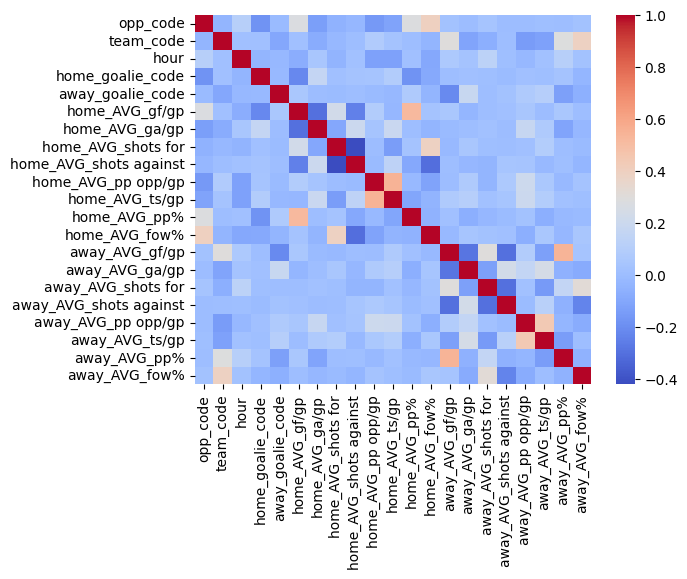

In [28]:
cols = ['opp_code', 'team_code', 'hour', 'home_goalie_code', 'away_goalie_code', 'home_AVG_gf/gp', 'home_AVG_ga/gp', 'home_AVG_shots for', 'home_AVG_shots against', 'home_AVG_pp opp/gp', 'home_AVG_ts/gp', 'home_AVG_pp%', 'home_AVG_fow%', 'away_AVG_gf/gp', 'away_AVG_ga/gp', 'away_AVG_shots for', 'away_AVG_shots against', 'away_AVG_pp opp/gp', 'away_AVG_ts/gp', 'away_AVG_pp%', 'away_AVG_fow%']
visualize_correlations(combined_nhl_game_data_2024, cols)

### Step 6: Preprocessing

In [29]:
feature_cols = [
    'team_code', 
    'opp_code', 
    'home_goalie_code', 
    'away_goalie_code',
    'rest_days_home', 
    'rest_days_away', 
    'home_AVG_gf/gp',
    'away_AVG_gf/gp',
    'home_AVG_ga/gp',
    'away_AVG_ga/gp',
    'home_AVG_pp%',
    'away_AVG_pp%',
    'home_AVG_fow%',
    'away_AVG_fow%',
    'home_AVG_sv%',
    'away_AVG_sv%'
]

Splitting training/testing data

In [30]:
from sklearn.model_selection import train_test_split

# Define features and target
X = combined_nhl_game_data_2024[feature_cols]
y = combined_nhl_game_data_2024['home_win']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# # Ensure the 'date' column is in datetime format
# combined_nhl_game_data_2024['date'] = pd.to_datetime(combined_nhl_game_data_2024['date'])

# # Sort the data by date
# combined_nhl_game_data_2024 = combined_nhl_game_data_2024.sort_values(by='date')

# # Define a specific date to split the data
# train_end_date = '2024-12-25'  # The date up to which the training data should go

# # Split the data based on the date
# train_data = combined_nhl_game_data_2024[combined_nhl_game_data_2024['date'] <= train_end_date]
# test_data = combined_nhl_game_data_2024[combined_nhl_game_data_2024['date'] > train_end_date]

# # Separate features and target for both training and testing sets
# X_train = train_data[feature_cols]
# y_train = train_data['home_win']
# X_test = test_data[feature_cols]
# y_test = test_data['home_win']



### Step 7: Hyperparameter Tuning

In [31]:
# model = RandomForestClassifier(random_state=1)

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 20, None],
#     'min_samples_split': [5, 10, 20],
#     'min_samples_leaf': [2, 5, 10],
#     'max_features': ['auto', 'sqrt', 'log2', None]
# }

# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=1),
#     param_grid,
#     cv=5,
#     scoring='accuracy'
# )

# grid_search.fit(X_train, y_train)
# print(f"Best Parameters: {grid_search.best_params_}")
# print(f"Best Cross-validation Score: {grid_search.best_score_}")

### Training The Model

In [32]:
# model = RandomForestClassifier(min_samples_leaf=10, min_samples_split=15, n_estimators=250, random_state=1, max_depth=15, class_weight='balanced')
# model.fit(X_train, y_train)

model = RandomForestClassifier(max_depth=None, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50, random_state=1, class_weight='balanced')
model.fit(X_train, y_train)

# model = RandomForestClassifier(max_depth=8, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100, random_state=1, class_weight='balanced')
# model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=None,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=50, random_state=1)

### Step 8: weighing accuracy

In [33]:
# Evaluate the model
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.5921052631578947
              precision    recall  f1-score   support

           0       0.58      0.57      0.58        74
           1       0.60      0.62      0.61        78

    accuracy                           0.59       152
   macro avg       0.59      0.59      0.59       152
weighted avg       0.59      0.59      0.59       152



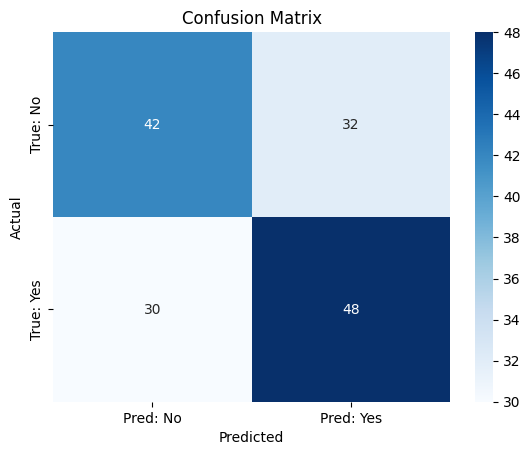

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: No', 'Pred: Yes'], yticklabels=['True: No', 'True: Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Step 9: Find feature importances

In [35]:
importances = model.feature_importances_

# Create a DataFrame to easily view and sort feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance
sorted_features = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display sorted feature importances
print(sorted_features)

# Optionally, you can remove features with very low importance (e.g., importance < 0.01)
low_importance_features = sorted_features[sorted_features['Importance'] < 0.01]
print(f"Low importance features: {low_importance_features['Feature'].tolist()}")

             Feature  Importance
12     home_AVG_fow%    0.090795
14      home_AVG_sv%    0.088973
9     away_AVG_ga/gp    0.078817
6     home_AVG_gf/gp    0.077517
15      away_AVG_sv%    0.077497
10      home_AVG_pp%    0.076487
8     home_AVG_ga/gp    0.072044
11      away_AVG_pp%    0.070909
3   away_goalie_code    0.064675
7     away_AVG_gf/gp    0.059017
0          team_code    0.057302
13     away_AVG_fow%    0.054747
1           opp_code    0.052611
2   home_goalie_code    0.051345
4     rest_days_home    0.017795
5     rest_days_away    0.009468
Low importance features: ['rest_days_away']


In [36]:
# Include home_team and away_team names
test_results = X_test.copy()
test_results['home_team'] = combined_nhl_game_data_2024.loc[X_test.index, 'home_team']
test_results['away_team'] = combined_nhl_game_data_2024.loc[X_test.index, 'away_team']
test_results['date'] = combined_nhl_game_data_2024.loc[X_test.index, 'date']

# Add actual results
test_results['Actual'] = y_test.values

# Add predicted results
test_results['Predicted'] = y_pred

# Add probabilities of home win (if required)
test_results['Predicted_Prob'] = model.predict_proba(X_test)[:, 1]

# Display the first few rows of the results with team names
cols = ['date', 'home_team', 'away_team', 'Actual', 'Predicted', 'Predicted_Prob']
test_results[cols].loc[test_results['date'] == '2025-01-12']

,date,home_team,away_team,Actual,Predicted,Predicted_Prob
619,2025-01-12,Detroit Red Wings,Seattle Kraken,1,1,0.62653


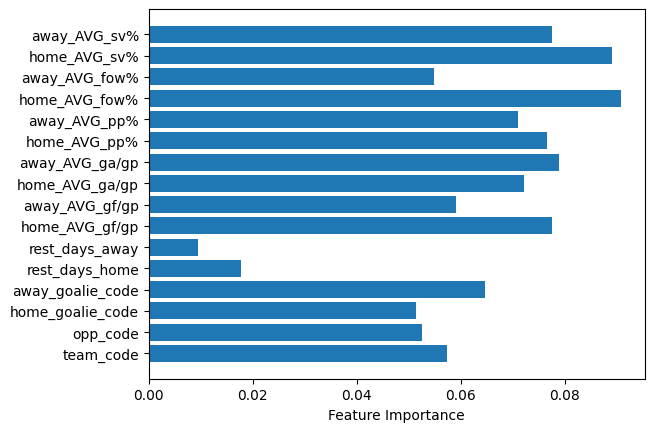

In [37]:
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_
features = X_test.columns
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.show()


### Export Model

In [38]:
import pickle

#save the model
pickle.dump(model, open('model.pkl', 'wb'))

In [39]:
future_game = {
    'date': ['2025-01-19'],
    'hour': [19],
    'team_code': [combined_nhl_game_data_2024[combined_nhl_game_data_2024['home_team'] == 'Montreal Canadiens']['team_code'].values[0]],
    'opp_code': [combined_nhl_game_data_2024[combined_nhl_game_data_2024['away_team'] == 'New York Rangers']['opp_code'].values[0]],
    'home_goalie_code': [37],
    'away_goalie_code': [48],
    'rest_days_home': [1],
    'rest_days_away': [1],
    'home_AVG_gf/gp': [3.00],
    'home_AVG_ga/gp': [3.31],
    'home_AVG_pp%': [20.9],
    'home_AVG_fow%': [49.7],
    'home_AVG_sv%': [.900],
    'away_AVG_gf/gp': [2.87],
    'away_AVG_ga/gp': [3.04],
    'away_AVG_pp%': [18.6],
    'away_AVG_fow%': [53.7],
    'away_AVG_sv%': [.963],
}

future_game = pd.DataFrame(future_game)
future_game = future_game[feature_cols]
prediction = model.predict(future_game)
if prediction == 1:
    print("Montreal Will win (home)")
else:
    print("Rangers will win (away)")

Montreal Will win (home)


In [40]:
# # get Ottawa Senators avg stats from their last 3 games
# import pandas as pd

# def get_avg_team_stas(team_name, combined_nhl_game_data):
#     # Filter games where the team is either home or away
#     home_games = combined_nhl_game_data[combined_nhl_game_data['home_team'] == team_name]
#     away_games = combined_nhl_game_data[combined_nhl_game_data['away_team'] == team_name]
    
#     # Concatenate home and away games
#     team = pd.concat([home_games, away_games], ignore_index=True)
    
#     # Sort by date in descending order
#     team = team.sort_values(by='date', ascending=False)
    
#     # Select the most recent 3 games
#     team = team.head(3)
    
#     # Return only the required feature columns
#     team = team[feature_cols]

#     avg_home_AVG_gf = team['home_AVG_gf/gp'].mean()
#     avg_home_AVG_ga = team['home_AVG_ga/gp'].mean()
#     avg_home_AVG_pp = team['home_AVG_pp%'].mean()
#     avg_home_AVG_fow = team['home_AVG_fow%'].mean()

#     return avg_home_AVG_gf, avg_home_AVG_ga, avg_home_AVG_pp, avg_home_AVG_fow




In [41]:
# # Get the average stats for the Ottawa Senators
# home_team = get_avg_team_stas('Detroit Red Wings', combined_nhl_game_data_2024)
# print(home_team)

In [42]:
# # Get the average stats for the Dallas Stars
# away_team = get_avg_team_stas('Seattle Kraken', combined_nhl_game_data_2024)
# print(away_team)

In [43]:
# ott_dal_game = {
#     'date': ['2025-01-12'],
#     'hour': [17],
#     'team_code': [combined_nhl_game_data_2024[combined_nhl_game_data_2024['home_team'] == 'Ottawa Senators']['team_code'].values[0]],
#     'opp_code': [combined_nhl_game_data_2024[combined_nhl_game_data_2024['away_team'] == 'Dallas Stars']['opp_code'].values[0]],
#     'home_goalie_code': [
#         combined_nhl_game_data_2024[
#             (combined_nhl_game_data_2024['home_goalie'] == 'Leevi Meriläinen') |
#             (combined_nhl_game_data_2024['away_goalie'] == 'Leevi Meriläinen')
#         ]['home_goalie_code'].values[0]
#     ],
#     'away_goalie_code': [combined_nhl_game_data_2024[combined_nhl_game_data_2024['away_goalie'] == 'Casey DeSmith']['away_goalie_code'].values[0]],
#     'rest_days_home': [0],
#     'rest_days_away': [0],
#     'home_AVG_gf/gp': [2.89],
#     'home_AVG_ga/gp': [3.40],
#     'home_AVG_pp%': [25.09],
#     'home_AVG_fow%': [51.72],
#     'away_AVG_gf/gp': [2.90],
#     'away_AVG_ga/gp': [3.57],
#     'away_AVG_pp%': [17.10],
#     'away_AVG_fow%': [51.09]
# }

# ott_dal_game = pd.DataFrame(ott_dal_game)
# ott_dal_game = ott_dal_game[feature_cols]
# prediction = model.predict(ott_dal_game)
# if prediction == 1:
#     print("Ottawa Senators will win")
# else:
#     print("Dallas Stars will win")

In [44]:
# combined_nhl_game_data_2024.loc[combined_nhl_game_data_2024['away_goalie'] == 'Philipp Grubauer']

In [45]:
# det_sea_game = {
#     'date': ['2025-01-12'],
#     'hour': [17],
#     'team_code': [combined_nhl_game_data_2024[combined_nhl_game_data_2024['home_team'] == 'Detroit Red Wings']['team_code'].values[0]],
#     'opp_code': [combined_nhl_game_data_2024[combined_nhl_game_data_2024['away_team'] == 'Seattle Kraken']['opp_code'].values[0]],
#     'home_goalie_code': [
#         combined_nhl_game_data_2024[
#             (combined_nhl_game_data_2024['home_goalie'] == 'Cam Talbot') |
#             (combined_nhl_game_data_2024['away_goalie'] == 'Cam Talbot')
#         ]['home_goalie_code'].values[0]
#     ],
#     'away_goalie_code': [combined_nhl_game_data_2024[combined_nhl_game_data_2024['away_goalie'] == 'Philipp Grubauer']['away_goalie_code'].values[0]],
#     'rest_days_home': [1],
#     'rest_days_away': [0],
#     'home_AVG_gf/gp': [3.06],
#     'home_AVG_ga/gp': [3.10],
#     'home_AVG_pp%': [26.10],
#     'home_AVG_fow%': [50.41],
#     'away_AVG_gf/gp': [3.10],
#     'away_AVG_ga/gp': [3.41],
#     'away_AVG_pp%': [21.25],
#     'away_AVG_fow%': [48.19]
# }

# det_sea_game = pd.DataFrame(det_sea_game)
# det_sea_game = det_sea_game[feature_cols]
# prediction = model.predict(det_sea_game)
# if prediction == 1:
#     print("Detroit Red Wings will win")
# else:
#     print("Seattle Kraken will win")